In [1]:
# Import the necessary libraries first
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import chi2, r_regression
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
import yfinance as yf
import talib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import LSTM,Dropout, BatchNormalization, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential
from keras.optimizer_v2.adam import Adam
from keras.regularizers import L1L2

In [2]:
data=yf.download('0005.hk',"2017-09-28","2021-09-24")
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-09-28,76.400002,77.099998,76.050003,76.199997,64.386993,22520013
2017-09-29,76.500000,76.900002,76.300003,76.550003,64.682732,16766252
2017-10-03,76.800003,77.449997,76.699997,77.449997,65.443199,24369212
2017-10-04,77.500000,77.949997,77.500000,77.849998,65.781204,21197563
2017-10-06,77.599998,77.800003,77.199997,77.349998,65.358711,23715110


In [3]:
data['Prediction']=data['Close'].shift(-1)
data.head()

,Open,High,Low,Close,Adj Close,Volume,Prediction
Date,,,,,,,
2017-09-28,76.400002,77.099998,76.050003,76.199997,64.386993,22520013,76.550003
2017-09-29,76.500000,76.900002,76.300003,76.550003,64.682732,16766252,77.449997
2017-10-03,76.800003,77.449997,76.699997,77.449997,65.443199,24369212,77.849998
2017-10-04,77.500000,77.949997,77.500000,77.849998,65.781204,21197563,77.349998
2017-10-06,77.599998,77.800003,77.199997,77.349998,65.358711,23715110,77.500000


In [4]:
data['H-L'] = data['High'] - data['Low']
data['O-C'] = data['Close'] - data['Open']
data["% Change"]=data["Close"].shift(1).pct_change()
data['3day MA'] = data['Close'].shift(1).rolling(window = 3).mean()
data['10day MA'] = data['Close'].shift(1).rolling(window = 10).mean()
data['30day MA'] = data['Close'].shift(1).rolling(window = 30).mean()
data['Std_dev']= data['Close'].shift(1).rolling(5).std()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 9)
# data['Williams %R'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 7)
data.head()

,Open,High,Low,Close,Adj Close,Volume,Prediction,H-L,O-C,% Change,3day MA,10day MA,30day MA,Std_dev,RSI
Date,,,,,,,,,,,,,,,
2017-09-28,76.400002,77.099998,76.050003,76.199997,64.386993,22520013,76.550003,1.049995,-0.200005,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-29,76.500000,76.900002,76.300003,76.550003,64.682732,16766252,77.449997,0.599998,0.050003,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-03,76.800003,77.449997,76.699997,77.449997,65.443199,24369212,77.849998,0.750000,0.649994,0.004593,NaN,NaN,NaN,NaN,NaN
2017-10-04,77.500000,77.949997,77.500000,77.849998,65.781204,21197563,77.349998,0.449997,0.349998,0.011757,76.733332,NaN,NaN,NaN,NaN
2017-10-06,77.599998,77.800003,77.199997,77.349998,65.358711,23715110,77.500000,0.600006,-0.250000,0.005165,77.283333,NaN,NaN,NaN,NaN


In [5]:
data.dropna(inplace=True)

In [6]:
# Feature extraction
X=data.drop('Prediction',1)
Y=data['Prediction'].values.reshape(-1,1)
test = SelectKBest(score_func=r_regression, k=5)
fit = test.fit(X, Y)

# Summarize scores
np.set_printoptions(precision=3)
print(fit.scores_)

features = fit.transform(X)
# Summarize selected features
print(features[0:5,:])

[ 0.998  0.998  0.999  0.999  0.99  -0.295 -0.102  0.031  0.026  0.997
  0.994  0.983 -0.08   0.129]
[[75.9   76.25  75.6   75.65  75.717]
 [75.2   75.45  75.05  75.15  75.817]
 [75.15  75.3   75.05  75.1   75.583]
 [75.5   75.7   75.25  75.35  75.3  ]
 [75.35  75.65  75.1   75.25  75.2  ]]


/home/gordon/anaconda3/envs/FYP/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [7]:
cols = list(X.columns)
model = LinearRegression()
rfe = RFE(model)
fit = rfe.fit(X, Y)
temp = pd.Series(fit.support_,index = cols)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Num Features: 7
Selected Features: [ True False  True  True False False  True  True  True False False False
  True False]
Feature Ranking: [1 7 1 1 3 8 1 1 1 2 4 5 1 6]
Index(['Open', 'Low', 'Close', 'H-L', 'O-C', '% Change', 'Std_dev'], dtype='object')


In [8]:
ridge = Ridge(alpha=1.0)
ridge.fit(X,Y)

/home/gordon/anaconda3/envs/FYP/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.3464e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Ridge()

In [9]:
#no of features
nof_list=np.arange(1,16)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,n_features_to_select=nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 14
Score with 14 features: 0.997778


In [10]:
cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, n_features_to_select=6)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,Y)  
#Fitting the data to model
model.fit(X_rfe,Y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['Open', 'Low', 'Close', 'H-L', 'O-C', '% Change'], dtype='object')


In [11]:
reg = LassoCV()
reg.fit(X, Y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,Y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 91024.672644
Best score using built-in LassoCV: 0.087253


/home/gordon/anaconda3/envs/FYP/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:1572: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
X.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'H-L', 'O-C',
       '% Change', '3day MA', '10day MA', '30day MA', 'Std_dev', 'RSI'],
      dtype='object')

In [13]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 1 variables and eliminated the other 13 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

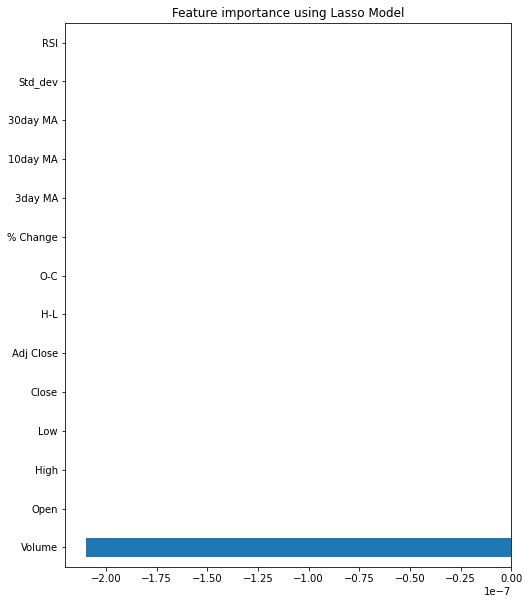

In [14]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [15]:
def correlation(dataset,threshold):
    col_corr=set() # set will contains unique values.
    corr_matrix=dataset.corr() #finding the correlation between columns.
    for i in range(len(corr_matrix.columns)): #number of columns
        for j in range(i):
            if abs(corr_matrix.iloc[i,j])>threshold: #checking the correlation between columns.
                colName=corr_matrix.columns[i] #getting the column name
                col_corr.add(colName) #adding the correlated column name heigher than threshold value.
    return col_corr #returning set of column names
col=correlation(X,0.8)
print('Correlated columns:',col) 

Correlated columns: {'Low', '10day MA', 'Close', 'Adj Close', '30day MA', 'High', '3day MA'}


In [16]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
#I am going to use RandomForestRegressor algoritham as an estimator. Your can select other regression alogritham as well.
from sklearn.ensemble import RandomForestRegressor
#k_features=10 (It will get top 10 features best suited for prediction)
#forward=True (Forward feature selection model)
#verbose=2 (It will show details output as shown below.)
#cv=5 (Kfold cross valiation: it will split the training set in 5 set and 4 will be using for training the model and 1 will using as validation)
#n_jobs=-1 (Number of cores it will use for execution.-1 means it will use all the cores of CPU for execution.)
#scoring='r2'(R-squared is a statistical measure of how close the data are to the fitted regression line)
forward_model=sfs(RandomForestRegressor(),k_features=10,forward=True,verbose=2,cv=5,n_jobs=-1,scoring='r2')
forward_model.fit(X_train,y_train.ravel())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:    1.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    1.8s finished

[2021-12-26 05:09:39] Features: 1/10 -- score: 0.9959404693371496[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  13 | elapsed:    1.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    1.4s finished

[2021-12-26 05:09:40] Features: 2/10 -- score: 0.9964817454826285[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    0.9s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.2s finished

[2021-12-26 05:09:41] Features: 3/10 -- score: 0.996734186501613[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of 

SequentialFeatureSelector(estimator=RandomForestRegressor(), k_features=10,
                          n_jobs=-1, scoring='r2', verbose=2)

In [17]:
#Get the selected feature index.
forward_model.k_feature_idx_

(0, 2, 3, 6, 7, 8, 10, 11, 12, 13)

In [18]:
#Get the column name for the selected feature.
forward_model.k_feature_names_

('Open',
 'Low',
 'Close',
 'H-L',
 'O-C',
 '% Change',
 '10day MA',
 '30day MA',
 'Std_dev',
 'RSI')

In [19]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.ensemble import RandomForestRegressor
#k_features=10 (It will get top 10 features best suited for prediction)
#forward=False (Backward feature selection model)
#verbose=2 (It will show details output as shown below.)
#cv=5 (Kfold cross valiation: it will split the training set in 5 set and 4 will be using for training the model and 1 will using as validation)
#n_jobs=-1 (Number of cores it will use for execution.-1 means it will use all the cores of CPU for execution.)
#scoring='r2'(R-squared is a statistical measure of how close the data are to the fitted regression line)
backwardModel=sfs(RandomForestRegressor(),k_features=10,forward=False,verbose=2,cv=5,n_jobs=-1,scoring='r2')
#We will convert our training data into numpy array. If we will not convert it, model is not able to read some of the column names. 
backwardModel.fit(np.array(X_train),y_train.ravel())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:    1.9s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    2.1s finished

[2021-12-26 05:09:54] Features: 13/10 -- score: 0.9967517808285635[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  13 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    1.9s finished

[2021-12-26 05:09:56] Features: 12/10 -- score: 0.9967946273932263[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.7s finished

[2021-12-26 05:09:58] Features: 11/10 -- score: 0.9967749253251279[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out

SequentialFeatureSelector(estimator=RandomForestRegressor(), forward=False,
                          k_features=10, n_jobs=-1, scoring='r2', verbose=2)

In [20]:
#Get the selected feature index.
backwardModel.k_feature_idx_

(0, 1, 3, 4, 6, 7, 8, 10, 12, 13)

In [21]:
#Get the column name for the selected feature.
X_train.columns[list(backwardModel.k_feature_idx_)]

Index(['Open', 'High', 'Close', 'Adj Close', 'H-L', 'O-C', '% Change',
       '10day MA', 'Std_dev', 'RSI'],
      dtype='object')

In [22]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector as efs
#min_features=1 (minimum number of feature)
#max_features=5 (maximum number of feature)
#n_jobs=-1 (Number of cores it will use for execution.-1 means it will use all the cores of CPU for execution.)
#scoring='r2'(R-squared is a statistical measure of how close the data are to the fitted regression line)
emodel=efs(RandomForestRegressor(),min_features=1,max_features=5,scoring='r2',n_jobs=-1)
#Lets take only 10 features which we got from backward feature selection.
miniData=X_train[X_train.columns[list(backwardModel.k_feature_idx_)]]

emodel.fit(np.array(miniData),y_train.ravel())
#If you see below the model creates 637 feature combinations from 10 features.Thats why its computationally very expensive.

Features: 637/637

ExhaustiveFeatureSelector(estimator=RandomForestRegressor(), max_features=5,
                          n_jobs=-1, scoring='r2')

In [23]:
#Get the selected feature index.
emodel.best_idx_

(0, 2, 7, 8, 9)

In [24]:
#Get the column name for the selected feature.
miniData.columns[list(emodel.best_idx_)]

Index(['Open', 'Close', '10day MA', 'Std_dev', 'RSI'], dtype='object')

In [25]:
emodel=efs(RandomForestRegressor(),min_features=1,max_features=7,scoring='r2',n_jobs=-1)
#Lets take only 10 features which we got from backward feature selection.
miniData_forward=X_train[X_train.columns[list(forward_model.k_feature_idx_)]]

emodel.fit(np.array(miniData_forward),y_train.ravel())
#If you see below the model creates 637 feature comb

Features: 967/967

ExhaustiveFeatureSelector(estimator=RandomForestRegressor(), max_features=7,
                          n_jobs=-1, scoring='r2')

In [26]:
#Get the selected feature index.
emodel.best_idx_

(0, 2, 4, 7, 8, 9)

In [27]:
#Get the column name for the selected feature.
miniData_forward.columns[list(emodel.best_idx_)]

Index(['Open', 'Close', 'O-C', '30day MA', 'Std_dev', 'RSI'], dtype='object')

In [28]:
data_selected=data[miniData_forward.columns[list(emodel.best_idx_)]]

In [29]:
data_selected['Prediction']=data['Prediction']
data_selected=data_selected[:-5]
data_unseen=data_selected[-5:]

<ipython-input-29-b909f1970ec0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected['Prediction']=data['Prediction']


In [30]:
# Build the LSTM model
adam = Adam(lr=0.001)
reg=L1L2(l1=0.00, l2=0.1)
BATCH_SIZE=20
X=data_selected.drop('Prediction',1).values
sc = MinMaxScaler(feature_range=(-1,1))
sc_y = MinMaxScaler(feature_range=(-1,1))
X=sc.fit_transform(X)
X = X.reshape(X.shape[0], 1, X.shape[1])
y=data_selected['Prediction'].values.reshape(-1,1)
y=sc_y.fit_transform(y)
print(y)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
model = Sequential()
model.add(LSTM(128, batch_input_shape=(BATCH_SIZE, 1,X_train.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0,
                        stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform',
                        bias_regularizer=reg))
model.add(Dropout(0.7))

model.add(LSTM(64, dropout=0.0))
model.add(Dropout(0.5))
    
model.add(Dense(32))
model.add(Dense(1))
# model.add(LSTM(7,input_shape=(1, X.shape[2]),bias_regularizer=reg,dropout=0.4,unit_forget_bias=False,return_sequences=True))
# model.add(Dense(1))
model.compile(
  loss="mean_squared_error",
  optimizer=adam
)

/home/gordon/anaconda3/envs/FYP/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:357: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


[[ 6.288e-01]
 [ 6.271e-01]
 [ 6.357e-01]
 [ 6.323e-01]
 [ 6.271e-01]
 [ 6.444e-01]
 [ 6.912e-01]
 [ 6.635e-01]
 [ 6.687e-01]
 [ 6.860e-01]
 [ 6.912e-01]
 [ 7.277e-01]
 [ 7.277e-01]
 [ 7.242e-01]
 [ 7.173e-01]
 [ 7.051e-01]
 [ 6.618e-01]
 [ 6.670e-01]
 [ 6.860e-01]
 [ 7.381e-01]
 [ 7.398e-01]
 [ 7.953e-01]
 [ 7.814e-01]
 [ 7.467e-01]
 [ 7.572e-01]
 [ 7.745e-01]
 [ 7.728e-01]
 [ 7.814e-01]
 [ 7.971e-01]
 [ 7.901e-01]
 [ 7.971e-01]
 [ 7.953e-01]
 [ 8.422e-01]
 [ 8.300e-01]
 [ 8.144e-01]
 [ 8.248e-01]
 [ 8.144e-01]
 [ 8.300e-01]
 [ 8.699e-01]
 [ 9.376e-01]
 [ 9.254e-01]
 [ 9.393e-01]
 [ 9.636e-01]
 [ 9.722e-01]
 [ 9.861e-01]
 [ 9.844e-01]
 [ 9.705e-01]
 [ 9.948e-01]
 [ 1.000e+00]
 [ 9.879e-01]
 [ 9.948e-01]
 [ 9.722e-01]
 [ 9.393e-01]
 [ 9.428e-01]
 [ 9.376e-01]
 [ 9.254e-01]
 [ 8.959e-01]
 [ 8.005e-01]
 [ 7.971e-01]
 [ 8.144e-01]
 [ 7.901e-01]
 [ 7.762e-01]
 [ 7.901e-01]
 [ 8.630e-01]
 [ 9.202e-01]
 [ 8.300e-01]
 [ 8.526e-01]
 [ 7.814e-01]
 [ 7.849e-01]
 [ 7.814e-01]
 [ 7.485e-01]
 [ 7.2

In [31]:
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (20, 1, 128)              69120     
_________________________________________________________________
dropout (Dropout)            (20, 1, 128)              0         
_________________________________________________________________
lstm_1 (LSTM)                (20, 64)                  49408     
_________________________________________________________________
dropout_1 (Dropout)          (20, 64)                  0         
_________________________________________________________________
dense (Dense)                (20, 32)                  2080      
_________________________________________________________________
dense_1 (Dense)              (20, 1)                   33        
Total params: 120,641
Trainable params: 120,641
Non-trainable params: 0
__________________________________________________

In [32]:
#Fit model with history to check for overfitting
es = EarlyStopping(monitor='val_loss', mode='min',patience=3)
history = model.fit(X_train,y_train,epochs=1200,batch_size=BATCH_SIZE,validation_data=(X_test,y_test),shuffle=False, callbacks=[es])

Epoch 1/1200
26/34 [=====================>........] - ETA: 0s - loss: 12.9028  

InvalidArgumentError:    Specified a list with shape [20,6] from a tensor with shape [2,6]
	 [[{{node TensorArrayUnstack/TensorListFromTensor}}]]
	 [[sequential/lstm/PartitionedCall]] [Op:__inference_train_function_4694]

Function call stack:
train_function -> train_function -> train_function


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_test=sc_y.inverse_transform(y_test)
y_pred=sc_y.inverse_transform(y_pred)
y_pred.shape

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [ ]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r',marker='*', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
print(y_pred)

In [ ]:
print(y_test)

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

In [ ]:
#model.save('HSBC_FeatureSelected')

In [ ]:
data_unseen

In [ ]:
unseen_data=sc.fit_transform(data_unseen.drop('Prediction',1).values)
unseen_data=unseen_data.reshape(unseen_data.shape[0],1,unseen_data.shape[1])
unseen_pred=model.predict(unseen_data)
unseen_pred=sc_y.inverse_transform(unseen_pred)
unseen_test=data_unseen['Prediction'].values.reshape(-1,1)
print(unseen_pred)
print(unseen_test)

In [ ]:
plt.plot(data_unseen['Prediction'].values, marker='.', label="true")
plt.plot(unseen_pred, 'r',marker='*', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
r2_score(data_unseen['Prediction'].values,unseen_pred)